In [125]:
import pandas as pd
import numpy as np
import gpflow
from gpflow.utilities import print_summary
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
%matplotlib inline

In [2]:
aurn = pd.read_csv("data/formatted/aurn_jan1st.csv")
print(aurn.head())

   time   latitude  longitude        val
0     1  50.371670  -4.142361   6.191667
1     1  50.411463  -4.227678   6.429167
2     1  50.735454  -1.780888  10.250000
3     1  50.739570  -1.826744   9.291667
4     1  50.805778   0.271611   5.991667


In [6]:
cams = pd.read_csv("data/formatted/cams_janst.csv")

In [7]:
cams.head()

,lat,lon,pm,time
0,49.8,-10.6,6.074860,0
1,49.9,-10.6,6.093135,0
2,50.0,-10.6,6.187524,0
3,50.1,-10.6,6.289507,0
4,50.2,-10.6,6.357866,0


In [9]:
print(f"Counts:\n\tAURN: {aurn.shape[0]}\n\tCAMS: {cams.shape[0]}")

Counts:
	AURN: 441
	CAMS: 84000


# Fit AURN model

In [120]:
XA = aurn[['latitude', 'longitude', 'time']].values
yA = aurn.val.values.reshape(-1, 1)

In [121]:
def standardise(X):
    Xmean = np.mean(X, axis=0)
    Xstd = np.std(X, axis=0)
    return (X-Xmean)/Xstd, Xmean, Xstd

Xtr, Xmean, Xstd = standardise(XA)

In [122]:
ytr = np.log(yA)
ymean = np.mean(ytr)
ytr_cent = ytr-ymean

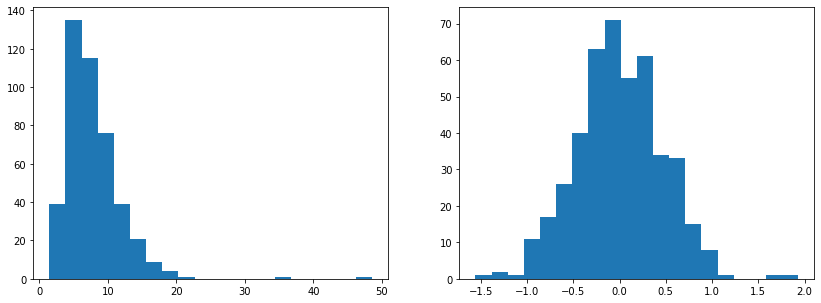

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].hist(yA, bins=20);
ax[1].hist(ytr_cent, bins=20);

In [131]:
kern = gpflow.kernels.Matern32(lengthscales=[1/np.sqrt(Xtr.shape[1])]*Xtr.shape[1])
mAurn = gpflow.models.GPR((Xtr, ytr_cent), kernel=kern)
print_summary(mAurn, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.57735027 0.57735027 0.57735027]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [132]:
opt = tf.optimizers.Adam(learning_rate=0.005)
nits = 3000
logfs = []

def scheduler(nit):
    if nit > 2500 and nit < 5000:
        return 0.005
    if nit > 5001 and nit < 7500:
        return 0.001
    if nit > 7501:
        return 0.001


for i in range(nits):
#     lr = scheduler(i)
#     opt.learning_rate = lr
    opt.minimize(mAurn.training_loss, mAurn.trainable_variables)
    loss = -mAurn.training_loss().numpy()
    if i % 50 == 0:
        print(f"Step {i}: {loss: .2f}")
    logfs.append(loss)


Step 0: -507.44
Step 50: -466.08
Step 100: -424.38
Step 150: -382.99
Step 200: -342.65
Step 250: -304.24
Step 300: -268.67
Step 350: -236.58
Step 400: -208.45
Step 450: -184.87
Step 500: -166.27
Step 550: -152.46
Step 600: -142.75
Step 650: -136.30
Step 700: -132.28
Step 750: -129.95
Step 800: -128.66
Step 850: -127.98
Step 900: -127.62
Step 950: -127.43
Step 1000: -127.32
Step 1050: -127.26
Step 1100: -127.21
Step 1150: -127.19
Step 1200: -127.16
Step 1250: -127.15
Step 1300: -127.13
Step 1350: -127.12
Step 1400: -127.12
Step 1450: -127.11
Step 1500: -127.10
Step 1550: -127.09
Step 1600: -127.09
Step 1650: -127.08
Step 1700: -127.07
Step 1750: -127.07
Step 1800: -127.06
Step 1850: -127.06
Step 1900: -127.05
Step 1950: -127.04
Step 2000: -127.04
Step 2050: -127.03
Step 2100: -127.02
Step 2150: -127.02
Step 2200: -127.01
Step 2250: -127.00
Step 2300: -127.00
Step 2350: -126.99
Step 2400: -126.99
Step 2450: -126.98
Step 2500: -126.97
Step 2550: -126.97
Step 2600: -126.96
Step 2650: -126.

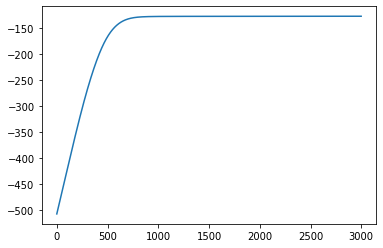

In [133]:
plt.plot(logfs)

In [134]:
print_summary(mAurn, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.32432305680928103
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.88055589 3.64245419 0.84858977]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.06540194954905176


## Make preds

In [135]:
shp = gpd.read_file("data/UK_boundary_shp/")

In [136]:
XC = (cams[["lat", "lon", "time"]].values-Xmean)/Xstd

In [137]:
mu, sigma = mAurn.predict_y(XC)
mu_tr = np.exp(mu + ymean)
sigma_tr = np.exp(sigma+ymean)

In [138]:
Xretr = (XC*Xstd)+Xmean
preds = pd.DataFrame(np.hstack((Xretr, mu_tr, sigma_tr)), columns=['lat', 'lon', 'time', 'mu', 'sigma'])
preds.head()

,lat,lon,time,mu,sigma
0,49.8,-10.6,0.0,6.700010,10.019542
1,49.9,-10.6,0.0,6.702801,9.999797
2,50.0,-10.6,0.0,6.709739,9.981554
3,50.1,-10.6,0.0,6.721161,9.965049
4,50.2,-10.6,0.0,6.737316,9.950459


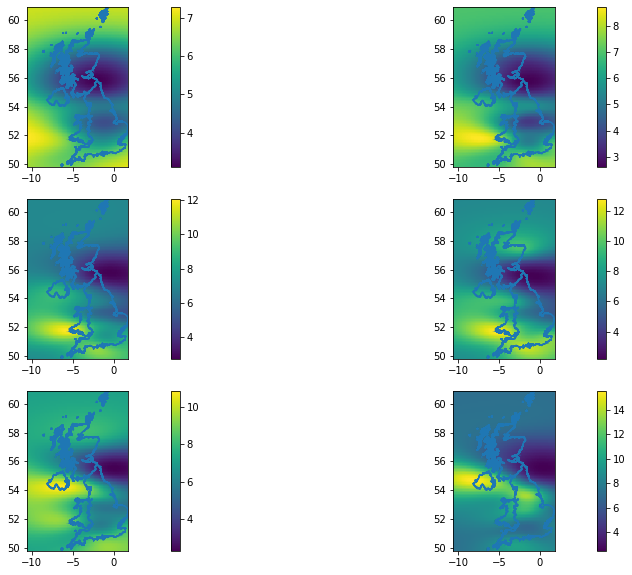

In [140]:
times = preds.time.drop_duplicates().tolist()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

for time, ax in zip(times, axes.ravel()):
    p = preds[preds.time == time]
    temp = p[['lat', 'lon', 'mu']]
    piv = temp.pivot(index='lat', columns='lon', values='mu')
    im = ax.pcolormesh(piv.columns, piv.index, piv, cmap='viridis')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    shp.boundary.plot(ax = ax)

# TODO

* Check CRS are equal in CAMS and AURN
* Fit both models using MCMC